In [2]:
import numpy as np
from scipy.stats import zscore
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)
S=zscore(S,axis=1)
proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


In [5]:
print(motSVD.shape)

(500, 30560)


In [3]:
from wavelets import WaveletAnalysis

# given a signal x(t)
x =S[0,:]
# and a sample spacing
dt = 0.25

wa = WaveletAnalysis(x, dt=dt)

# wavelet power spectrum
power = wa.wavelet_power

# scales 
scales = wa.scales

# associated time vector
t = wa.time

/home/maria/anaconda3/lib/python3.7/site-packages/wavelets/transform.py:104: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  wavelet_data[slices],


In [4]:
print(power.shape)

(112, 30560)


In [16]:
from keras import backend
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

In [23]:
# multivariate cnn example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
in_seq1 = power[0,0:1000]
in_seq2 = power[1,0:1000]
out_seq = motSVD[0,:1000]
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse',metrics=[rmse])
# fit model
history=model.fit(X, y, epochs=1000, verbose=0)
# demonstrate prediction
#x_input = array([[80, 85], [90, 95], [100, 105]])
#x_input = x_input.reshape((1, n_steps, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

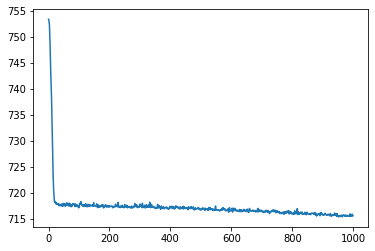

In [24]:
# plot metrics
import matplotlib.pyplot as plt
plt.plot(history.history['rmse'])
plt.show()


In [25]:
in_seq1_test = power[0,1000:2000]
in_seq2_test = power[1,1000:2000]
out_seq_test = motSVD[0,1000:2000]
# convert to [rows, columns] structure
in_seq1_test = in_seq1.reshape((len(in_seq1_test), 1))
in_seq2_test = in_seq2.reshape((len(in_seq2_test), 1))
out_seq_test = out_seq.reshape((len(out_seq_test), 1))
# horizontally stack columns
dataset = hstack((in_seq1_test, in_seq2_test, out_seq_test))
X, y = split_sequences(dataset, n_steps)
model.evaluate(X, y, verbose=0)

[608585.1966432866, 715.33935546875]